# Test control vars for loanword authors
Let's extract and test some control variables as a way to explain loanword use:

- geography
- L2 use
- prior loanword use
- hashtag/URL sharing??

### Load data

In [2]:
import pandas as pd
import os
integrated_loanword_author_data_dir = '../../data/mined_tweets/loanword_integrated_verb_author_counts_CLUSTER=twitter_posts_tweets/'
light_verb_loanword_author_data_dir = '../../data/mined_tweets/loanword_light_verb_author_counts_CLUSTER=twitter_posts_tweets/'
integrated_loanword_author_data_files = list(map(lambda x: os.path.join(integrated_loanword_author_data_dir, x), os.listdir(integrated_loanword_author_data_dir)))
light_verb_loanword_author_data_files = list(map(lambda x: os.path.join(light_verb_loanword_author_data_dir, x), os.listdir(light_verb_loanword_author_data_dir)))
# load data
integrated_loanword_author_data = pd.concat(list(map(lambda x: pd.read_csv(x, sep='\t', index_col=False, compression='gzip'), integrated_loanword_author_data_files)))
light_verb_loanword_author_data = pd.concat(list(map(lambda x: pd.read_csv(x, sep='\t', index_col=False, compression='gzip'), light_verb_loanword_author_data_files)))
print('%d integrated data'%(integrated_loanword_author_data.shape[0]))
print('%d light verb data'%(light_verb_loanword_author_data.shape[0]))

1101904 integrated data
394832 light verb data


In [7]:
# also get loanword counts for later
f = '../../data/mined_tweets/loanword_integrated_verb_author_counts_CLUSTER=twitter_posts.tsv'

def load_broken_csv_data(file_name, sep='\t', CLEAN_FIELDS=4):
    header = None
    header_clean = None
    data = []
    l_clean = []
    for i, l in enumerate(open(file_name, 'r')):
        l = l.strip()
        l_split = l.split('\t')
        if(i == 0):
            header = l_split
            header_clean = header[:CLEAN_FIELDS]
            NUM_FIELDS = len(header)
        elif(len(l_split) >= CLEAN_FIELDS and len(l_split) <= NUM_FIELDS):
            data.append(l_split)
    data = pd.DataFrame(data, columns=header)
    # filter bad rows
    for header_field in header_clean:
        data = data[(data.loc[:, header_field] != '')]
    return data
integrated_loanword_author_counts = load_broken_csv_data('../../data/mined_tweets/loanword_integrated_verb_author_counts_CLUSTER=twitter_posts.tsv', sep='\t', CLEAN_FIELDS=4)
light_verb_loanword_author_counts = load_broken_csv_data('../../data/mined_tweets/loanword_light_verb_author_counts_CLUSTER=twitter_posts.tsv', sep='\t', CLEAN_FIELDS=4)
print(integrated_loanword_author_counts.shape[0])
print(light_verb_loanword_author_counts.shape[0])
integrated_loanword_author_counts = integrated_loanword_author_counts.assign(**{
    'light_verb_use' : 0
})
light_verb_loanword_author_counts = light_verb_loanword_author_counts.assign(**{
    'light_verb_use' : 1
})
combined_loanword_use_data = pd.concat([integrated_loanword_author_counts, light_verb_loanword_author_counts], axis=0)
combined_loanword_use_data = combined_loanword_use_data.assign(**{
    'author' : combined_loanword_use_data.loc[:, 'user_screen_name']
})
print(combined_loanword_use_data.shape[0])

143176


In [8]:
author_descriptive_data = combined_loanword_use_data.drop_duplicates(['author'], inplace=False).loc[:, ['author', 'user_description', 'user_location']]
author_descriptive_data.fillna('', inplace=True)
display(author_descriptive_data.head())

,author,user_description,user_location
0,Flavius85349047,,
1,LeoCastillokk,Ser dé Racing,"Morón, Argentina"
2,FreroPlopsGames,Tiesto,
3,Lizyllen,"Mamá de 3, profesora universitaria, asesora co...",Venezuela
4,viridiane_Welle,,


### Extract location
Easiest control variable is geography. Let's keep it simple and define three classes for location:

- in Latin America
- in US
- other
- n/a

#### Extract location: build locations from scratch

Matching strategy:

- ends with country name
- ends with state name
- matches nearly-unambiguous name (next biggest candidate <= 10x population)

In [5]:
geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False)

In [6]:
display(geonames_data.head())

,geonames_ID,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population,alternate_name_count
0,2986043,Pic de Font Blanca,"Pic de Font Blanca,Pic du Port",42.64991,1.53335,T,PK,AD,0,2
1,2994701,Roc Mélé,"Roc Mele,Roc Meler,Roc Mélé",42.58765,1.74028,T,MT,AD,0,3
2,3007683,Pic des Langounelles,Pic des Langounelles,42.61203,1.47364,T,PK,AD,0,1
3,3017832,Pic de les Abelletes,"Pic de la Font-Negre,Pic de la Font-Nègre,Pic ...",42.52535,1.73343,T,PK,AD,0,3
4,3017833,Estany de les Abelletes,"Estany de les Abelletes,Etang de Font-Negre,Ét...",42.52915,1.73362,H,LK,AD,0,3


In [7]:
import re
country_feat_code = 'PCLI'
latin_america_bounds = [[26.512, -58.354], [-116.893, -32.444]]
latin_america_geonames = geonames_data[(geonames_data.loc[:, 'latitude'] <= latin_america_bounds[0][0]) &
                                       (geonames_data.loc[:, 'latitude'] >= latin_america_bounds[0][1]) &
                                       (geonames_data.loc[:, 'longitude'] >= latin_america_bounds[1][0]) &
                                       (geonames_data.loc[:, 'longitude'] <= latin_america_bounds[1][1])]
country_prefix = re.compile('^.+ of ')
country_rename_pairs = [(re.compile('Argentine Republic'), 'Argentina')]
latin_america_country_geonames = latin_america_geonames[latin_america_geonames.loc[:, 'feature_code']==country_feat_code]
latin_america_country_geonames = latin_america_country_geonames.assign(**{
    'name' : latin_america_country_geonames.loc[:, 'name'].apply(lambda x: country_prefix.sub('', x))
})
for country_name_matcher, country_rename in country_rename_pairs:
    latin_america_country_geonames = latin_america_country_geonames.assign(**{
        'name' : latin_america_country_geonames.loc[:, 'name'].apply(lambda x: country_name_matcher.sub(country_rename, x))
    })
# add extra names
latin_america_country_names = latin_america_country_geonames.loc[:, 'name'].values.tolist()
extra_country_names = ['Brasil']
latin_america_country_names += extra_country_names
print(latin_america_country_names)
latin_america_country_codes = list(latin_america_country_geonames.loc[:, 'country'].unique())
print(latin_america_country_codes)
latin_america_country_code_lookup = {}
for latin_america_country_name in latin_america_country_names:
    latin_america_country_name_geonames = latin_america_country_geonames[latin_america_country_geonames.loc[:, 'name']==latin_america_country_name]
    if(latin_america_country_name_geonames.shape[0] > 0):
        latin_america_country_name_geonames = latin_america_country_name_geonames.iloc[0, :]
        latin_america_country_code_lookup[latin_america_country_name] = latin_america_country_name_geonames.loc['country']
# add extra for Argentina
latin_america_country_code_lookup['Argentina'] = 'AR'
print(latin_america_country_code_lookup)

['Antigua and Barbuda', 'Argentina', 'Barbados', 'Bolivia', 'Brazil', 'The Bahamas', 'Belize', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador', 'Grenada', 'Guatemala', 'Guyana', 'Honduras', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis', 'Saint Lucia', 'Mexico', 'Nicaragua', 'Panama', 'Peru', 'Paraguay', 'Suriname', 'El Salvador', 'Trinidad and Tobago', 'Uruguay', 'Saint Vincent and the Grenadines', 'Venezuela', 'Brasil']
['AG', 'AR', 'BB', 'BO', 'BR', 'BS', 'BZ', 'CL', 'CO', 'CR', 'CU', 'DM', 'DO', 'EC', 'GD', 'GT', 'GY', 'HN', 'HT', 'JM', 'KN', 'LC', 'MX', 'NI', 'PA', 'PE', 'PY', 'SR', 'SV', 'TT', 'UY', 'VC', 'VE']
{'Antigua and Barbuda': 'AG', 'Argentina': 'AR', 'Barbados': 'BB', 'Bolivia': 'BO', 'Brazil': 'BR', 'The Bahamas': 'BS', 'Belize': 'BZ', 'Chile': 'CL', 'Colombia': 'CO', 'Costa Rica': 'CR', 'Cuba': 'CU', 'Dominica': 'DM', 'Dominican Republic': 'DO', 'Ecuador': 'EC', 'Grenada': 'GD', 'Guatemala': 'GT', 'Guyana': 'GY', 'Honduras': 'HN', 'H

In [8]:
state_feat_code = 'ADM1'
us_geonames = geonames_data[geonames_data.loc[:, 'country']=='US']
us_state_geonames = us_geonames[us_geonames.loc[:, 'feature_code']==state_feat_code]
display(us_state_geonames.head())

,geonames_ID,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population,alternate_name_count
9110514,4099753,Arkansas,"'Akanaka,A-khen-set,AR,Akennsas,Arcansas,Arcan...",34.75037,-92.50044,A,ADM1,US,2757631,78
9148629,4138106,District of Columbia,"D.C.,DC,District de Columbia,District of Colum...",38.91706,-77.00025,A,ADM1,US,552433,21
9152717,4142224,Delaware,"DE,Delauaare,Delauare,Delaue""r,Delavar,Delavar...",39.00039,-75.49992,A,ADM1,US,838549,79
9166185,4155751,Florida,"FL,Floarida,Florid,Florida,Florida Shitati,Flo...",28.75054,-82.50010,A,ADM1,US,17671452,76
9207263,4197000,Georgia,"Chacha,Dzhordzhija,Estado de Georgia,GA,Georgi...",32.75042,-83.50018,A,ADM1,US,8975842,19


In [9]:
# get names and alternate name (2-letter state abbreve)
us_state_names = us_state_geonames.loc[:, 'name'].values.tolist()
state_abbreve_matcher = re.compile('[A-Z]{2}')
us_state_abbreve_names = us_state_geonames.loc[:, 'alternate_names'].apply(lambda x: list(filter(lambda y: state_abbreve_matcher.search(y) is not None, x.split(',')))[0]).values.tolist()

In [10]:
latin_america_country_matcher = re.compile('(%s)$'%('|'.join(list(map(lambda x: x.lower(), latin_america_country_names)))))
us_state_abbreve_names_combined = us_state_names + us_state_abbreve_names
us_state_matcher = re.compile(', (%s)$|^(%s)$'%('|'.join(list(map(lambda x: x.lower(), us_state_abbreve_names_combined))), '|'.join(list(map(lambda x: x.lower(), us_state_names)))))

In [11]:
# get unambiguous city names
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import clean_txt_simple
importance_var = 'population'
importance_ratio = 10
city_feature_codes = ['PPL', 'PPLA', 'PPLA2', 'PPLA3']
city_geonames = geonames_data[geonames_data.loc[:, 'feature_code'].isin(city_feature_codes)].sort_values(importance_var, inplace=False, ascending=False)
city_geonames = city_geonames.assign(**{
    'name_clean' : city_geonames.loc[:, 'name'].apply(clean_txt_simple)
})
unambig_city_geonames = []
for name_i, data_i in city_geonames.groupby('name_clean'):
    data_i.sort_values(importance_var, inplace=True, ascending=False)
    if(data_i.shape[0] > 1):
        match_1_i = data_i.iloc[0, :]
        match_2_i = data_i.iloc[1, :]
        if(match_1_i.loc['population'] >= match_2_i.loc['population']*importance_ratio):
            unambig_city_geonames.append(match_1_i)
    else:
        unambig_city_geonames.append(data_i.iloc[0, :])
unambig_city_geonames = pd.concat(unambig_city_geonames, axis=1).transpose()
# remove invalid names with bad chars e.g. "*"
valid_unambig_city_geonames = []
for name_i, data_i in unambig_city_geonames.groupby('name_clean'):
    try:
        re.compile(name_i)
        valid_unambig_city_geonames.append(data_i)
    except Exception as e:
        pass
valid_unambig_city_geonames = pd.concat(valid_unambig_city_geonames, axis=0)
unambig_city_matcher = re.compile('|'.join(map(lambda x: f'^{x}$', valid_unambig_city_geonames.loc[:, 'name_clean'].values)))
unambig_city_country_lookup = dict(zip(valid_unambig_city_geonames.loc[:, 'name_clean'].values, 
                                       valid_unambig_city_geonames.loc[:, 'country'].values))

/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


#### Extract location: load location data

TODO: Load location data from file.

In [ ]:
us_state_matcher = []
latin_american_country_matcher = []
unambig_city_matcher = []
unambig_city_country_lookup = []


In [12]:
# process location data
def match_location_country(location, us_state_matcher, latin_america_country_matcher, 
                           unambig_city_matcher, unambig_city_country_lookup, 
                           latin_america_country_codes, us_country_code):
    clean_location = clean_txt_simple(location)
    us_state_match = us_state_matcher.search(location)
    latin_america_country_match = latin_america_country_matcher.search(location)
    location_country = ''
    if(us_state_match is not None):
        location_country = us_country_code
    elif(latin_america_country_match is not None):
        location_country = 'Latin_America'
    else:
        unambig_city_match = unambig_city_matcher.search(location)
        if(unambig_city_match is not None):
            unambig_city = unambig_city_match.group(0)
            if(unambig_city in unambig_city_country_lookup):
                unambig_city_country = unambig_city_country_lookup[unambig_city]
                if(unambig_city_country in latin_america_country_codes):
                    unambig_city_country = 'Latin_America'
                location_country = unambig_city_country
    return location_country

In [13]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import clean_txt_simple
location = 'houston'
us_country_code = 'US'
locations = ['houston', 'buenos aires, argentina', 'atlanta, ga']
for location in locations:
    print(f'location {location}')
    location_country = match_location_country(location, us_state_matcher, latin_america_country_matcher, unambig_city_matcher, unambig_city_country_lookup, latin_america_country_codes, us_country_code)
    print(location_country)

location houston
US
location buenos aires, argentina
Latin_America
location atlanta, ga
US


Extract locations for all valid authors.

In [14]:
def extract_location(data, us_state_matcher, latin_america_country_matcher, unambig_city_matcher, unambig_city_country_lookup, latin_america_country_codes, us_country_code):
    data = data.assign(**{
        'user_location_region' : data.loc[:, 'user_location'].apply(lambda x: match_location_country(clean_txt_simple(x), us_state_matcher, latin_america_country_matcher, unambig_city_matcher, unambig_city_country_lookup, latin_america_country_codes, us_country_code))
    })
    return data

In [15]:
author_descriptive_data = extract_location(author_descriptive_data, us_state_matcher, latin_america_country_matcher, unambig_city_matcher, unambig_city_country_lookup, latin_america_country_codes, us_country_code)
display(author_descriptive_data.head())

,author,user_description,user_location,user_location_region
0,05Salome,Concepción de la Sierra. Historia.YO CRISTINA ...,,
1,0hmyfuck,tengo prohibido por ley responder boludeces,argentina,Latin_America
2,0rlandoAraujo,"Las ideologías, creencias, estructuras de orga...",Caracas. Venezuela,Latin_America
3,100ziou,la vibra de tu cuerpo me está llamando,México,Latin_America
4,104luisin,Ni de izquierda o derecha no hay verdades abso...,,


In [16]:
print(author_descriptive_data.loc[:, 'user_location_region'].value_counts())

                 88417
Latin_America    37588
US                1941
ES                1314
PH                1256
                 ...  
AL                   1
VU                   1
LT                   1
KE                   1
LK                   1
Name: user_location_region, Length: 99, dtype: int64


### Load loanword author prior data

In [17]:
import re
import os
def load_combine_tweet_data(data_dir):
    data_files = list(filter(lambda x: x.endswith('.gz'), os.listdir(data_dir)))
    data = pd.concat(list(map(lambda x: pd.read_csv(os.path.join(data_dir, x), sep='\t', index_col=False, compression='gzip'), data_files)), axis=0)
    return data
integrated_loanword_author_data_dir = '../../data/mined_tweets/loanword_integrated_verb_author_counts_CLUSTER=twitter_posts_tweets/'
light_verb_loanword_author_data_dir = '../../data/mined_tweets/loanword_light_verb_author_counts_CLUSTER=twitter_posts_tweets/'
integrated_loanword_author_tweet_data = load_combine_tweet_data(integrated_loanword_author_data_dir)
light_verb_loanword_author_tweet_data = load_combine_tweet_data(light_verb_loanword_author_data_dir)
# clean nan vals
integrated_loanword_author_tweet_data.fillna('', inplace=True)
light_verb_loanword_author_tweet_data.fillna('', inplace=True)
# remove data without text??
integrated_loanword_author_tweet_data = integrated_loanword_author_tweet_data[integrated_loanword_author_tweet_data.loc[:, 'text']!='']
light_verb_loanword_author_tweet_data = light_verb_loanword_author_tweet_data[light_verb_loanword_author_tweet_data.loc[:, 'text']!='']
# fix user names
username_matcher = re.compile('(?<=https://twitter.com/)[a-zA-Z0-9_]+')
integrated_loanword_author_tweet_data = integrated_loanword_author_tweet_data.assign(**{
    'author' : integrated_loanword_author_tweet_data.loc[:, 'permalink'].apply(lambda x: username_matcher.search(x).group(0))
})
light_verb_loanword_author_tweet_data = light_verb_loanword_author_tweet_data.assign(**{
    'author' : light_verb_loanword_author_tweet_data.loc[:, 'permalink'].apply(lambda x: username_matcher.search(x).group(0))
})

In [18]:
print('%d tweets from integrated loanword authors'%(integrated_loanword_author_tweet_data.shape[0]))
print('%d tweets from light verb loanword authors'%(light_verb_loanword_author_tweet_data.shape[0]))

1087670 tweets from integrated loanword authors
389280 tweets from light verb loanword authors


In [40]:
# combine for later
integrated_loanword_author_tweet_data = integrated_loanword_author_tweet_data.assign(**{
    'author_type' : 'integrated_loanword',
})
light_verb_loanword_author_tweet_data = light_verb_loanword_author_tweet_data.assign(**{
    'author_type' : 'light_verb_loanword',
})
combined_loanword_author_tweet_data = pd.concat([integrated_loanword_author_tweet_data,
                                                 light_verb_loanword_author_tweet_data], axis=0)

### Extract L2 use
Using the previous tweets from loanword authors, let's approximate L2 use based on ES/EN use in original content (no RTs!).

In [30]:
from importlib import reload
import langid
reload(langi
from langid import langid
from langid.langid import LanguageIdentifier, model
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
# if we don't specify langs, we get a lot of false negatives from CA/PR (Catalan)
# identifier.set_languages(['en', 'es'])
print(identifier.classify('this is a test that I am doing'))
print(identifier.classify('qué dices? no comprendo'))
print(identifier.classify('ceci est une preuve que je fais'))
print(identifier.classify('私は先生になりたい'))

('en', 0.9999999999819291)
('pt', 0.787308379127033)
('fr', 1.0)
('ja', 1.0)


In [32]:
import re
from langid import langid
from langid.langid import LanguageIdentifier, model
USER_MATCHER = re.compile('@\s?[a-zA-Z_]+')
URL_MATCHER = re.compile('http.+')
def clean_txt_for_lang_id(txt):
    txt = USER_MATCHER.sub('', txt)
    txt = URL_MATCHER.sub('', txt)
    return txt

def extract_lang_data(data):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    # classify
    data = data.assign(**{
        'lang' : data.loc[:, 'text'].apply(lambda x: identifier.classify(clean_txt_for_lang_id(x)))
    })
    # separate lang/score
    data = data.assign(**{
        'lang_score' : data.loc[:, 'lang'].apply(lambda x: x[1])
    })
    data = data.assign(**{
        'lang' : data.loc[:, 'lang'].apply(lambda x: x[0])
    })
    return data

In [42]:
combined_loanword_author_tweet_data = extract_lang_data(combined_loanword_author_tweet_data)

In [43]:
# show language distribution
display(combined_loanword_author_tweet_data.loc[:, 'lang'].value_counts())

es    1035514
en     240539
pt      24225
it      23422
gl      17376
       ...   
gu          2
mr          2
uk          1
dz          1
mk          1
Name: lang, Length: 95, dtype: int64

In [37]:
# what if we restrict to high confidence labels?
lang_score_cutoff = 0.9
conf_lang_combined_loanword_author_tweet_data = combined_loanword_author_tweet_data[combined_loanword_author_tweet_data.loc[:, 'lang_score'] >= lang_score_cutoff]
display(conf_lang_combined_loanword_author_tweet_data.loc[:, 'lang'].value_counts())

es    926005
en     99318
ca      9906
it      8049
fr      7848
       ...  
bg         2
mn         2
mk         1
dz         1
ps         1
Name: lang, Length: 91, dtype: int64

Is there a difference in proportions between integrated loanword authors and light verb loanword authors?

In [294]:
# curiosity: is there a difference in proportions?
from scipy.stats import chi2_contingency
from scipy.stats import norm
contingency_table = pd.concat([integrated_loanword_author_tweet_data.loc[:, 'lang'].value_counts(), 
                               light_verb_loanword_author_tweet_data.loc[:, 'lang'].value_counts()], axis=1)
contingency_table_norm = contingency_table / contingency_table.sum(axis=0)
print(contingency_table)
print(contingency_table_norm)
test_stat, p_val, dof, expected = chi2_contingency(contingency_table.values)
print('chi2 test stat = %.3f (p=%.3E)'%(test_stat, p_val))

      lang    lang
es  878829  304596
en  208841   84684
        lang     lang
es  0.807992  0.78246
en  0.192008  0.21754
chi2 test stat = 1173.445 (p=3.602E-257)


Get the language percentage use per author.

In [205]:
def extract_lang_pct(data, lang='es'):
    lang_pct = data[data.loc[:, 'lang']==lang].shape[0] / data.shape[0]
    return lang_pct
author_lang_es_pct = combined_loanword_author_tweet_data.groupby('author').apply(lambda x: extract_lang_pct(x, lang='es')).reset_index().rename(columns={0:'es_pct'})
# author_lang_count_data = combined_loanword_author_tweet_data.groupby('author').apply(lambda x: x.loc[:, 'lang'].value_counts())
display(author_lang_es_pct)

,author,es_pct
0,000822e5bc974e0,0.890467
1,0063_tmi,0.662474
2,007martin,0.940000
3,00tropico_,0.647059
4,01Magena,0.924000
...,...,...
3535,zDxNix,0.726358
3536,zagez,0.869215
3537,zaraftlali,0.667339
3538,zazada287,0.937876


Let's also discretize this! We can separate authors based on their activity: monolingual (>=95%), medium bilingual (50%<x<95%), and low bilingual (<=50%).

In [1]:
def discretize_lang_pct(lang_pct, lang_bounds):
    lang_cat = ''
    for lang_cat_i, lang_bound_i in lang_bounds.items():
        if(lang_pct >= lang_bound_i[0] and lang_pct < lang_bound_i[1]):
            lang_cat = lang_cat_i
            break
    return lang_cat
lang_bounds = {
    'monolingual' : [0.95, 1.01],
    'med_bilingual' : [0.5, 0.95],
    'low_bilingual' : [0., 0.5]
}
author_lang_categories = author_lang_es_pct.assign(**{
    'es_lang_category' : author_lang_es_pct.loc[:, 'es_lang_pct'].apply(lambda x: discretize_lang_pct(x, lang_bounds))
})
display(author_lang_categories.loc[:, 'es_lang_category'].value_counts())

NameError: name 'author_lang_es_pct' is not defined

### Extract prior loanword use
Using the previous tweets from loanword authors, let's count prior loanword use => both integrated and light verb use.

In [176]:
import re
integrated_loanword_matcher_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs_integrated_verbs_query_phrases.tsv', sep='\t', index_col=False)
light_verb_loanword_matcher_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs_light_verbs_query_phrases.tsv', sep='\t', index_col=False)
# generate matchers
integrated_loanword_matcher_data = integrated_loanword_matcher_data.assign(**{
    'verb' : integrated_loanword_matcher_data.loc[:, 'verb'].apply(re.compile)
})
light_verb_loanword_matcher_data = light_verb_loanword_matcher_data.assign(**{
    'verb' : light_verb_loanword_matcher_data.loc[:, 'verb'].apply(re.compile)
})

In [209]:
def match_words(txt, word_matcher_pairs):
    # do not strip accents because of ambiguity
    txt_clean = txt.lower()
    words = []
    for word, matcher in word_matcher_pairs:
        if(matcher.search(txt_clean)):
            words.append(word)
    return words

def extract_loanwords(data, integrated_loanword_matcher_data, light_verb_loanword_matcher_data, txt_var='text'):
    integrated_loanword_matcher_pairs = list(zip(integrated_loanword_matcher_data.loc[:, 'loanword'].values, 
                                                 integrated_loanword_matcher_data.loc[:, 'verb'].values))
    light_verb_loanword_matcher_pairs = list(zip(light_verb_loanword_matcher_data.loc[:, 'loanword'].values, 
                                                 light_verb_loanword_matcher_data.loc[:, 'verb'].values))
    data = data.assign(**{
        'integrated_loanwords' : data.loc[:, txt_var].apply(lambda x: match_words(x, integrated_loanword_matcher_pairs)),
    })
    data = data.assign(**{
        'light_verb_loanwords' : data.loc[:, txt_var].apply(lambda x: match_words(x, light_verb_loanword_matcher_pairs)),
    })
    return data

In [ ]:
combined_loanword_author_tweet_data = extract_loanwords(combined_loanword_author_tweet_data, 
                                                        integrated_loanword_matcher_data, 
                                                        light_verb_loanword_matcher_data, 
                                                        txt_var='text')

In [214]:
from functools import reduce
integrated_loanword_counts = pd.Series(reduce(lambda x,y: x+y, combined_loanword_author_tweet_data.loc[:, 'integrated_loanwords'].values)).value_counts()
light_verb_loanword_counts = pd.Series(reduce(lambda x,y: x+y, combined_loanword_author_tweet_data.loc[:, 'light_verb_loanwords'].values)).value_counts()
print(integrated_loanword_counts)
print(light_verb_loanword_counts)

tick       36066
connect     1197
dope        1093
flip        1087
access      1037
           ...  
ghost          2
pump           2
freak          1
pack           1
exit           1
Length: 101, dtype: int64
look      200
like      177
DM        160
access    130
post       76
         ... 
upvote      1
freeze      1
limit       1
dope        1
hack        1
Length: 72, dtype: int64


In [215]:
from functools import reduce
from nltk.tokenize.toktok import ToktokTokenizer
# compute integrated and light verb counts
def get_word_pct(data, tokenizer, word_var='integrated_loanwords', txt_var='text'):
    # word count / total tokens
    word_count = len(list(reduce(lambda x,y: x+y, data.loc[:, word_var].values)))
    token_count = len(list(reduce(lambda x,y: x+y, data.loc[:, txt_var].apply(tokenizer.tokenize))))
    word_pct = word_count / token_count
    return word_pct
def get_word_pct_all_authors(data, word_var='integrated_loanwords', author_var='author', txt_var='text'):
    tokenizer = ToktokTokenizer()
    author_word_pct = data.groupby(author_var).apply(lambda x: get_word_pct(x, tokenizer, word_var=word_var, txt_var=txt_var))
    return author_word_pct

In [219]:
integrated_loanword_per_author_pct = get_word_pct_all_authors(combined_loanword_author_tweet_data, word_var='integrated_loanwords', author_var='author', txt_var='text')
light_verb_loanword_per_author_pct = get_word_pct_all_authors(combined_loanword_author_tweet_data, word_var='light_verb_loanwords', author_var='author', txt_var='text')
# fix columns
integrated_loanword_per_author_pct = integrated_loanword_per_author_pct.reset_index().rename(columns={0: 'integrated_loanword_pct'})
light_verb_loanword_per_author_pct = light_verb_loanword_per_author_pct.reset_index().rename(columns={0: 'light_verb_loanword_pct'})

In [221]:
display(integrated_loanword_per_author_pct.head())
display(light_verb_loanword_per_author_pct.head())

,author,integrated_loanword_pct
0,000822e5bc974e0,0.002736
1,0063_tmi,0.003747
2,007martin,0.001952
3,00tropico_,0.009524
4,01Magena,0.001431


,author,light_verb_loanword_pct
0,000822e5bc974e0,0.000000
1,0063_tmi,0.000000
2,007martin,0.000000
3,00tropico_,0.000000
4,01Magena,0.000143


### Extract hashtag, URL use
Using the previous tweets, let's look at hashtag and URL use.

In [238]:
import re
def get_simple_match(txt, matcher):
    match = matcher.search(txt)
    if(match is not None):
        return [match.group(0)]
    else:
        return ''
HASHTAG_MATCHER = re.compile('#\s?[a-zA-Z0-9]+')
URL_MATCHER = re.compile('[a-zA-Z0-9]+\.(com|org|edu|net|gov|co)/\w+|[a-zA-Z0-9]+\.[a-zA-Z0-9]+\.(com|org|edu|net|gov|co)/\w+')
combined_loanword_author_tweet_data = combined_loanword_author_tweet_data.assign(**{
    'hashtags' : combined_loanword_author_tweet_data.loc[:, 'text'].apply(HASHTAG_MATCHER.findall)
})
combined_loanword_author_tweet_data = combined_loanword_author_tweet_data.assign(**{
    'urls' : combined_loanword_author_tweet_data.loc[:, 'text'].apply(lambda x: get_simple_match(x, URL_MATCHER))
})

In [239]:
def get_list_counts(data, list_var='hashtags'):
    counts = []
    for l in data.loc[:, list_var].values:
        counts += l
    counts = pd.Series(counts).value_counts()
    return counts
hashtag_counts = get_list_counts(combined_loanword_author_tweet_data, list_var='hashtags')
url_counts = get_list_counts(combined_loanword_author_tweet_data, list_var='urls')
display(hashtag_counts)
display(url_counts)

# BBMAsTopSocial       4071
# KCAMexico            2644
# PremiosMTVMIAW       2171
# iHeartAwards         2113
# BTS                  1927
                       ... 
# TodosPresos             1
# SoySuperfacha           1
# mostrequestedlive       1
# Elda                    1
# ClipPlus                1
Length: 77696, dtype: int64

www.instagram.com/p                          10389
www.youtube.com/watch                         3415
open.spotify.com/track                        2106
www.facebook.com/story                        1439
twitter.com/i                                 1218
                                             ...  
twitter.com/tuiteroregio                         1
twitter.com/Josuecoronel420                      1
cocpic.twitter.com/YtoZR4XiFP                    1
www.noticiaszmg.com/zmg16165                     1
MorritzCalderonpic.twitter.com/yhtGmKoweX        1
Length: 258412, dtype: int64

In [250]:
# get URL and hashtag percent
author_var = 'author'
def get_post_pct_with_list_var(data, list_var='hashtags'):
    list_var_count = data[data.loc[:, list_var].apply(lambda x: len(x) > 0)].shape[0]
    post_pct = list_var_count / data.shape[0]
    return post_pct
author_hashtag_pct = combined_loanword_author_tweet_data.groupby(author_var).apply(lambda x: get_post_pct_with_list_var(x, list_var='hashtags')).reset_index().rename(columns={0 : 'hashtag_post_pct'})
author_url_pct = combined_loanword_author_tweet_data.groupby(author_var).apply(lambda x: get_post_pct_with_list_var(x, list_var='hashtags')).reset_index().rename(columns={0 : 'url_post_pct'})

In [254]:
display(author_hashtag_pct.head())
display(author_url_pct.head())

,author,hashtag_post_pct
0,000822e5bc974e0,0.523327
1,0063_tmi,0.004193
2,007martin,0.004000
3,00tropico_,0.000000
4,01Magena,0.168000


,author,url_post_pct
0,000822e5bc974e0,0.523327
1,0063_tmi,0.004193
2,007martin,0.004000
3,00tropico_,0.000000
4,01Magena,0.168000


### Age
Can we extract author age based on their descriptions? E.g. "yo tengo 20 años" => "20 years old".

In [37]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import clean_txt_simple
import re
age_regexes = [
    re.compile(r'(?:^|\s)([0-9]{2})\s*(?:•|&~)'),
    re.compile(r'\|\s+([0-9]{2})(?:\s|$)'),
    re.compile(r'(?:\s|^)([0-9]{2})\.(?:[^0-9]|$)'),
    re.compile(r'i\'m\s+([0-9]{2})(?:\s|$)', re.IGNORECASE),
    re.compile(r'^([0-9]{2})\s?[,.•|](?:[^0-9]|$)'),
    re.compile(r'[,.•|]\s?([0-9]{2})\s?[,.•|](?:[^0-9]|$)'),
    re.compile(r'\|\s([0-9]{2})\s\|'),
    # English ages
    re.compile(r'(?:^|\s)([0-9]{2})\s(?:y/o|years old|year old|year[s]? young|yrs young|yrs old|yo)\b', re.IGNORECASE),
    re.compile(r'(?:^|\s)([0-9]{2})(?:y/o|yo)\b', re.IGNORECASE),
    # Spanish ages
    re.compile(r'(?:^|\s)([0-9]{2})\s?(?:anos)'),
    # birth year
    re.compile(r'(?<=[,.•|\.\s])19[0-9]{2}')
               ]
combined_age_descriptions = []
def extract_age(txt, age_regexes):
    txt_clean = clean_txt_simple(txt)
    age = ''
    for age_regex in age_regexes:
        age_match = age_regex.search(txt)
        if(age_match is not None):
            age = age_match.group(0)
            break
    return age
author_descriptive_data = author_descriptive_data.assign(**{
    'age' : author_descriptive_data.loc[:, 'user_description'].apply(lambda x: extract_age(x, age_regexes))
})
valid_age_author_descriptive_data = author_descriptive_data[author_descriptive_data.loc[:, 'age']!='']
print('%d/%d age descriptions'%(valid_age_author_descriptive_data.shape[0], author_descriptive_data.shape[0]))

3689/131453 age descriptions


Are the age estimates accurate?

In [38]:
# are the age descriptions accurate?
display(valid_age_author_descriptive_data.loc[:, ['user_description', 'age']].head(10).values)

array([['Born in 1984, not that it looks like it.....', '1984'],
       ['20.', '20.'],
       ['23. AD. Owl. Bi. Veg🌱. Priest & Rogue. BTS V Fan /http://curiouscat.me/OwlVr',
        '23. '],
       ['⚓CIC. La vida en la mar. Automatic lover. La felicidad también se entrena. Babor y estribor de GUARDIA.MINATO 10 02.',
        ' 02.'],
       ['ElAntro.cl : El poder del ocio desde 1999', '1999'],
       ['Lvl 18.         ·Rolplayer·        @mrnacho95 ♡                             The ones who are smiling are the strongest.  『The souls are made of stars.☆』',
        ' 18. '],
       ['17. Twitch Partner Streamer. Instagram: Sergio_gelhzz. Business: gelhzz@gmail.com',
        '17. '],
       ['23, Intento de diseñador. @AxinenDesign', '23, '],
       ['Tirado desde 1992, aburrido y con ganas de comer.', '1992'],
       ['22•Ing. Industrial•UAQ•Gallos Blancos 🐓❤️⚽️•Todo se puede si te lo propones 👨🏼\u200d🎓🔜👷🏼\u200d♂️•Vamos a morirnos juntos 🖤🐔💙',
        '22•']], dtype=object)

Some of these seem OK but some are clearly mistakes like ".02".

In [40]:
# what are the most common ages?
def estimate_age_from_txt(age_txt, curr_year=2020):
    """
    Estimate age from txt:
    1. look for birth year
    2. look for age
    """
    age = 0
    age_matcher = re.compile('\d{2}')
    birth_year_matcher = re.compile('19[0-9]{2}')
    birth_year_match = birth_year_matcher.search(age_txt)
    if(birth_year_match is not None):
        birth_year = int(birth_year_match.group(0))
        age = curr_year - birth_year
    else:
        age_match = age_matcher.search(age_txt)
        age = int(age_match.group(0))
    return age
valid_age_author_descriptive_data = valid_age_author_descriptive_data.assign(**{
    'age_estimate' : valid_age_author_descriptive_data.loc[:, 'age'].apply(lambda x: estimate_age_from_txt(x))
})

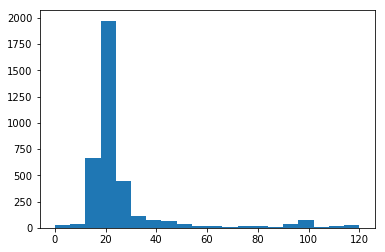

In [41]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(valid_age_author_descriptive_data.loc[:, 'age_estimate'], bins=20)
plt.show()

OK! Not surprisingly most loanword authors are in the 10-30 age range (reflecting Twitter at large).

We should eliminate the unlikely ages (<13, >80) and use the remaining distribution (for training?).

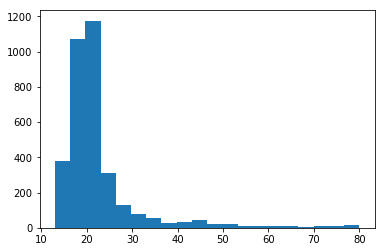

In [43]:
AGE_LOWER = 13
AGE_UPPER = 80
clean_age_author_descriptive_data = valid_age_author_descriptive_data[(valid_age_author_descriptive_data.loc[:, 'age_estimate'] >= AGE_LOWER) &
                                                                      (valid_age_author_descriptive_data.loc[:, 'age_estimate'] <= AGE_UPPER)]
plt.hist(clean_age_author_descriptive_data.loc[:, 'age_estimate'], bins=20)
plt.show()

Curiosity: if we bin the ages, how easily can we predict age from text?

In [50]:
import numpy as np
age_bins = [10, 20, 30]
bin_age_lookup = dict(zip(range(1,len(age_bins)+1), ['13-19', '20-30', '31+']))
age_bin_vals = np.digitize(clean_age_author_descriptive_data.loc[:, 'age_estimate'], age_bins)
age_bin_vals = list(map(bin_age_lookup.get, age_bin_vals))
print(pd.Series(age_bin_vals).value_counts())

20-30    1620
13-19    1449
31+       359
dtype: int64


In [78]:
# convert text to DTM
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer
TKNZR = ToktokTokenizer()
cv = CountVectorizer(min_df=0.001, max_df=0.5, tokenizer=TKNZR.tokenize)
txt = clean_age_author_descriptive_data.loc[:, 'user_description'].values
dtm = cv.fit_transform(txt)
cv_idx_vocab_lookup = dict(zip(cv.vocabulary_.values(), cv.vocabulary_.keys()))
print(dtm.shape)

(3428, 1293)


In [66]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
# let's try logistic to start
lr = LogisticRegression(multi_class='multinomial', max_iter=100, solver='lbfgs')
cv_results = cross_validate(lr, dtm, age_bin_vals, cv=5, scoring='f1_macro')

/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/loanword_adopti

In [67]:
print(cv_results['test_score'])

[0.83226069 0.85232467 0.8280113  0.82411376 0.82131077]


This is surprisingly good! What are the indicative features for each class?

In [68]:
lr = LogisticRegression(multi_class='multinomial', max_iter=100, solver='lbfgs')
lr_fit = lr.fit(dtm, age_bin_vals)

/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [86]:
lr_coef = pd.DataFrame(lr_fit.coef_)
# extract features from DTM
lr_coef.columns = list(map(cv_idx_vocab_lookup.get, range(lr_coef.shape[1])))
lr_coef.index = lr_fit.classes_
display(lr_coef.head())
# sort by weight
for class_i, coef_i in lr_coef.iterrows():
    print(f'testing class=<{class_i}>')
    coef_i.sort_values(inplace=True, ascending=False)
    display(coef_i.head(20))

,!,"""",#1,%,&#124;,&amp;,',(,),*,...,💥,💫,📚,📷,📸,🔥,🖤,😍,🥀,🦋
13-19,-0.232115,-0.050102,0.205946,-0.731136,0.134532,-0.508409,0.033122,-0.013760,-0.037271,0.293006,...,0.018627,0.045692,-0.007784,-0.500384,-0.124820,-0.028695,0.216510,0.100310,0.068116,-0.056099
20-30,-0.009370,-0.262792,-0.125609,0.845270,0.150455,0.456847,-0.008419,-0.193529,-0.111394,-0.222578,...,-0.006611,0.130074,0.099215,0.595299,0.149386,-0.350151,-0.156133,0.239525,-0.030700,0.113804
31+,0.241485,0.312894,-0.080337,-0.114134,-0.284987,0.051562,-0.024703,0.207289,0.148665,-0.070429,...,-0.012015,-0.175766,-0.091432,-0.094915,-0.024566,0.378846,-0.060378,-0.339835,-0.037416,-0.057704


testing class=<13-19>


19.      2.971311
18.      2.911070
17.      2.673907
18       2.514643
19       2.478075
16.      2.378065
17       2.351467
15.      1.902780
16       1.672049
15       1.612497
14.      1.512726
14       1.274796
13       1.240061
13.      0.995473
•18•     0.797127
está     0.785629
saber    0.766560
ganas    0.759033
river    0.758798
vos      0.698608
Name: 13-19, dtype: float64

testing class=<20-30>


20.     3.036047
21.     2.891386
22.     2.698432
23.     2.675992
21      2.674229
24.     2.367815
22      2.263732
20      2.232653
1999    2.033981
23      1.934144
1996    1.921667
26.     1.904390
25.     1.874411
1998    1.812268
24      1.569159
28      1.561961
1997    1.560895
28.     1.462014
1995    1.436935
1994    1.430824
Name: 20-30, dtype: float64

testing class=<31+>


1975          2.304655
1989          1.681461
1984          1.585730
1990          1.474797
1986          1.452858
1982          1.404019
1985          1.320403
nacido        1.219943
30            1.186099
30.           1.180219
36.           1.166398
desde         1.063517
1976          1.002741
1984.         0.982194
1981          0.972635
1987          0.964269
40            0.953004
ella          0.932774
periodista    0.926244
nací          0.886699
Name: 31+, dtype: float64

OK! So it learned to generalize to other numbers and predict age pretty readily. That's good! High precision, lower recall.


TODO: Can we apply this classifier to the unlabeled data to expand our pool of authors with age?

#### Verify age distribution
This age identification strategy seems legit but could lead to biased results.

Let's verify that the age distribution at an aggregate level is working.

One way to verify age distribution: look at occupations with known age distributions and compare their age distributions:

- college students (younger)
- teacher (older)

Let's find some of these keywords by looking at 2-gram frequency.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=0.001, max_df=0.5)
txt = 

TODO: scrape birthday information for author sub-set using the following HTML pattern:

`<span class="css-901oao css-16my406 r-1re7ezh r-4qtqp9 r-1qd0xha r-ad9z0x r-zso239 r-bcqeeo r-qvutc0"><svg viewBox="0 0 24 24" class="r-1re7ezh r-4qtqp9 r-yyyyoo r-1xvli5t r-7o8qx1 r-dnmrzs r-bnwqim r-1plcrui r-lrvibr"><g><path d="M7.75 11.083c-.414 0-.75-.336-.75-.75C7 7.393 9.243 5 12 5c.414 0 .75.336.75.75s-.336.75-.75.75c-1.93 0-3.5 1.72-3.5 3.833 0 .414-.336.75-.75.75z"></path><path d="M20.75 10.333c0-5.01-3.925-9.083-8.75-9.083s-8.75 4.074-8.75 9.083c0 4.605 3.32 8.412 7.605 8.997l-1.7 1.83c-.137.145-.173.357-.093.54.08.182.26.3.46.3h4.957c.198 0 .378-.118.457-.3.08-.183.044-.395-.092-.54l-1.7-1.83c4.285-.585 7.605-4.392 7.605-8.997zM12 17.917c-3.998 0-7.25-3.402-7.25-7.584S8.002 2.75 12 2.75s7.25 3.4 7.25 7.583-3.252 7.584-7.25 7.584z"></path></g></svg>Born October 26, 1947</span>`

## Predict loanword use
Now that everything is in place, let's do some prediction!

- loanword ~ geography + L2 + prior loanword + prior hashtag + prior URL

In [260]:
combined_loanword_use_author_attribute_data = combined_loanword_use_data.copy()
# geography
combined_loanword_use_author_attribute_data = pd.merge(combined_loanword_use_author_attribute_data, author_descriptive_data.loc[:, ['author', 'user_location_region']], on='author')
# language
combined_loanword_use_author_attribute_data = pd.merge(combined_loanword_use_author_attribute_data, author_lang_es_pct, on='author')
# loanword use
combined_loanword_use_author_attribute_data = pd.merge(combined_loanword_use_author_attribute_data, integrated_loanword_per_author_pct, on='author')
combined_loanword_use_author_attribute_data = pd.merge(combined_loanword_use_author_attribute_data, light_verb_loanword_per_author_pct, on='author')
# hashtag use
# URL use
combined_loanword_use_author_attribute_data = pd.merge(combined_loanword_use_author_attribute_data, author_hashtag_pct, on='author')
combined_loanword_use_author_attribute_data = pd.merge(combined_loanword_use_author_attribute_data, author_url_pct, on='author')

In [262]:
display(combined_loanword_use_author_attribute_data.head())

,loanword,author,author_id,time,count,user_description,user_location,light_verb_use,user_location_region,es_pct,integrated_loanword_pct,light_verb_loanword_pct,hashtag_post_pct,url_post_pct
0,access,0hmyfuck,762237043,"(2018, 7, 9)",1,tengo prohibido por ley responder boludeces,argentina,0,Latin_America,0.918,0.001487,0.0,0.002,0.002
1,google,0hmyfuck,762237043,"(2018, 7, 9)",1,tengo prohibido por ley responder boludeces,argentina,0,Latin_America,0.918,0.001487,0.0,0.002,0.002
2,connect,0hmyfuck,762237043,"(2019, 1, 3)",1,tengo prohibido por ley responder boludeces,argentina,0,Latin_America,0.918,0.001487,0.0,0.002,0.002
3,tick,0hmyfuck,762237043,"(2019, 1, 3)",1,tengo prohibido por ley responder boludeces,argentina,0,Latin_America,0.918,0.001487,0.0,0.002,0.002
4,access,0rlandoAraujo,130919424,"(2018, 7, 9)",1,"Las ideologías, creencias, estructuras de orga...",Caracas. Venezuela,0,Latin_America,0.942,0.003808,0.0,0.060,0.060


In [273]:
# remove invalid locations
valid_location_regions = ['US', 'Latin_America']
clean_loanword_use_author_attribute_data = combined_loanword_use_author_attribute_data[combined_loanword_use_author_attribute_data.loc[:, 'user_location_region'].isin(valid_location_regions)]

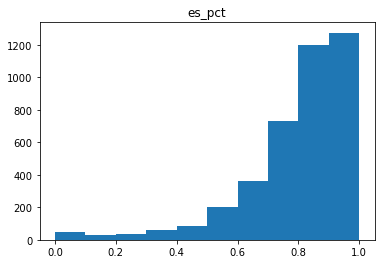

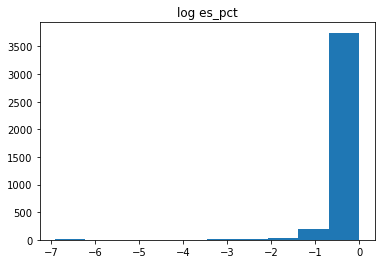

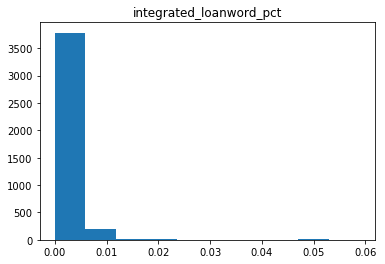

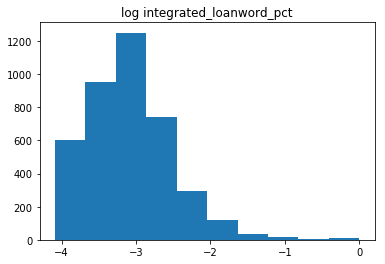

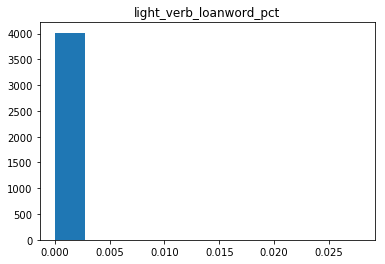

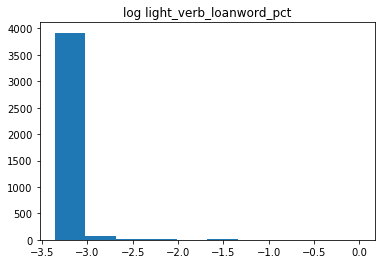

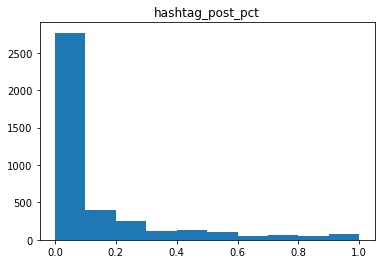

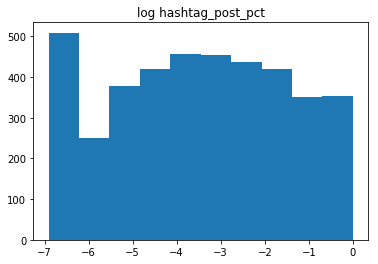

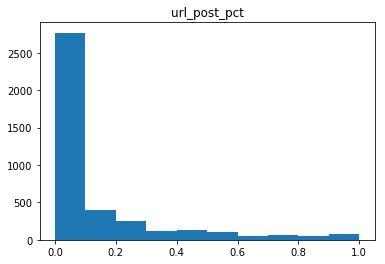

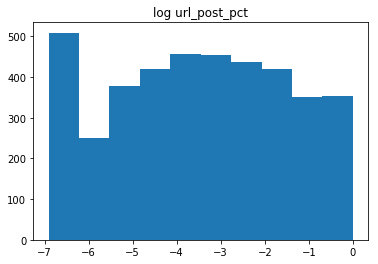

In [266]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# log-scale variables??
scalar_vars = ['es_pct', 'integrated_loanword_pct', 'light_verb_loanword_pct', 'hashtag_post_pct', 'url_post_pct']
for scalar_var in scalar_vars:
    plt.hist(combined_loanword_use_author_attribute_data.loc[:, scalar_var].values)
    plt.title(scalar_var)
    plt.show()
    smooth_val = 1e-3
    scalar_var_min = combined_loanword_use_author_attribute_data.loc[:, scalar_var].min()
    smooth_var = (combined_loanword_use_author_attribute_data.loc[:, scalar_var].values + smooth_val)
    smooth_var = smooth_var / (smooth_var.max() - scalar_var_min)
    plt.hist(np.log(smooth_var))
    plt.title(f'log {scalar_var}')
    plt.show()

In [269]:
def smooth_data(data, smooth_var=1e-3):
    data_min = data.min()
    data_smooth = data + smooth_var
    data_smooth = data_smooth / (data_smooth.max() - data_min)
    return data_smooth
scalar_vars_to_smooth = ['integrated_loanword_pct', 'hashtag_post_pct', 'url_post_pct']
smooth_var = 1e-3
for scalar_var in scalar_vars_to_smooth:
    combined_loanword_use_author_attribute_data = combined_loanword_use_author_attribute_data.assign(**{
        f'log_{scalar_var}' : np.log(smooth_data(combined_loanword_use_author_attribute_data.loc[:, scalar_var].values, smooth_var=smooth_var))
    })
log_scalar_vars = list(map(lambda x: f'log_{x}', scalar_vars_to_smooth))

In [1]:
from statsmodels.discrete.discrete_model import Logit
# TODO: why are hashtag/URL singular?
combined_scalar_vars = ['es_pct'] + ['hashtag_post_pct'] #+ ['integrated_loanword_pct', 'light_verb_loanword_pct'] => perfect prediction
categorical_vars = ['user_location_region']
combined_scalar_var_str = '+'.join(combined_scalar_vars)
categorical_var_str = '+'.join(list(map(lambda x: f'C({x})', categorical_vars)))
dep_var = 'light_verb_use'
formula = f'{dep_var} ~ {combined_scalar_var_str} + {categorical_var_str}'
logit_model = Logit.from_formula(formula, clean_loanword_use_author_attribute_data)
model_results = logit_model.fit()
display(model_results.summary())

/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NameError: name 'clean_loanword_use_author_attribute_data' is not defined

OK! The strongest effect by far is the `es_pct` which is behaving as expected: more Spanish correlates with more integrated verb use (same as before with light verb authors vs. integrated verb authors).

In [ ]:
# TODO: run again but only with common loanwords for per-loanword effects